In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torchvision import datasets

from models import Classifier, cross_entropy_with_grad
from optimizers import MomentumSGD
from gradient_check import *
from layers import *

In [3]:
np.random.seed(42)

## Загружаем и обрабатываем данные

In [4]:
train_dataset = datasets.MNIST('./data', train=True, download=True)
X_train, y_train = train_dataset.data.numpy(), train_dataset.targets.numpy()

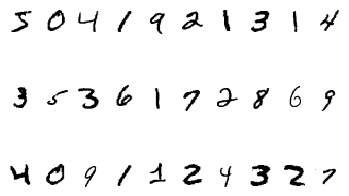

In [5]:
for plot_index in range(30):
    plt.subplot(3, 10, plot_index + 1)
    plt.imshow(X_train[plot_index], cmap=plt.cm.gray_r)
    plt.axis('off')

In [6]:
X_train = X_train.astype(float, copy=False) / 255

mean, std = 0.1307, 0.3081
X_train = (X_train - mean) / std

X_train = X_train[:, :, :, np.newaxis]
print(f'Train shape: {X_train.shape}')

Train shape: (60000, 28, 28, 1)


## Проверим градиенты слоёв

In [7]:
X, y = X_train[:1], y_train[:1]
X.shape, y.shape

((1, 28, 28, 1), (1,))

# Conv2d

In [8]:
layer = Conv2d(in_channels=1, out_channels=2, kernel_size=3)
assert check_layer_gradient(layer, X)
assert check_layer_parameter_gradient(layer, X, parameter_id=0)
assert check_layer_parameter_gradient(layer, X, parameter_id=1)

Gradient check passed!
Gradient check passed!
Gradient check passed!


## MaxPool2d

In [9]:
check_layer_gradient(MaxPool2d(2, 2), X)

Gradients are different at (0, 0, 0, 0). Analytic: -0.44594371386116016, Numeric: -0.2229718568003136


False

### Почему же так получилось? Взглянем на пиксели в углу нашей картинки 28x28

In [10]:
X[0,:,:,0].shape

(28, 28)

In [11]:
X[0,:,:,0][:4,:4]

array([[-0.42421292, -0.42421292, -0.42421292, -0.42421292],
       [-0.42421292, -0.42421292, -0.42421292, -0.42421292],
       [-0.42421292, -0.42421292, -0.42421292, -0.42421292],
       [-0.42421292, -0.42421292, -0.42421292, -0.42421292]])

### У нас MaxPool 2x2. Значит, когда в наш квадратик 2x2 попадают несколько значений, которые являются максимумом, мы отправляем градиент во все пиксели, где было максимальное значение. В этом случае посчитанный градиент будет неверным. Однако, маловероятно, что это случится на практике. Одно из возможных решений - разделить градиент поровну между максимальными пикселями. К сожалению, такая реализация приведёт к снижению производительности.

### Посмотрим на случай, когда в квадратике один максимум

In [12]:
X_pool_test = np.array([
              [
               [[1.0, 0.0], [2.0, 1.0]],
               [[0.0, -1.0], [-1.0, -2.0]]
              ]
              ,
              [
               [[0.0, 1.0], [1.0, -1.0]],
               [[-2.0, 2.0], [-1.0, 0.0]]
              ]
             ])
print(f'Shape: {X_pool_test.shape}', end='\n\n')
print(X_pool_test[0,:,:,0], end='\n\n')
print(X_pool_test[1,:,:,0], end='\n\n')
print(X_pool_test[0,:,:,1], end='\n\n')
print(X_pool_test[1,:,:,1], end='\n\n')
assert check_layer_gradient(MaxPool2d(2, 2), X_pool_test)

Shape: (2, 2, 2, 2)

[[ 1.  2.]
 [ 0. -1.]]

[[ 0.  1.]
 [-2. -1.]]

[[ 0.  1.]
 [-1. -2.]]

[[ 1. -1.]
 [ 2.  0.]]

Gradient check passed!


### В этом случае градиент верный!

## Flattener

In [13]:
assert check_layer_gradient(Flattener(), X)

Gradient check passed!


## Dropout

In [14]:
assert check_layer_gradient(Dropout(p=0.5, train=True, grad_check=True), X)

Gradient check passed!


## ReLU

In [15]:
assert check_layer_gradient(ReLU(), X)

Gradient check passed!


## Linear

In [16]:
layer = Linear(28 * 28, 4)
X_flattened = Flattener().forward(X)
assert check_layer_gradient(layer, X_flattened)
assert check_layer_parameter_gradient(layer, X_flattened, parameter_id=0)
assert check_layer_parameter_gradient(layer, X_flattened, parameter_id=1)

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Последовательность слоёв

In [17]:
model = Classifier([Conv2d(in_channels=1, out_channels=2, kernel_size=5),
                    MaxPool2d(4, 4),
                    ReLU(),
                    Conv2d(in_channels=2, out_channels=4, kernel_size=3),
                    ReLU(),
                    Flattener(),
                    Linear(4 * 4 * 4, 32),
                    ReLU(),
                    Dropout(p=0.5, train=True, grad_check=True),
                    Linear(32, 10)])

check_model_gradient(model, X, y, cross_entropy_with_grad)

Checking gradient. W/B shape: (25, 2)
Gradients are different at (0, 1). Analytic: -0.004031461885862383, Numeric: -0.026493509475145057
Checking gradient. W/B shape: (2,)
Gradients are different at (1,). Analytic: 0.009503352373807956, Numeric: 0.062453626492597884
Checking gradient. W/B shape: (18, 4)
Gradient check passed!
Checking gradient. W/B shape: (4,)
Gradient check passed!
Checking gradient. W/B shape: (64, 32)
Gradient check passed!
Checking gradient. W/B shape: (32,)
Gradient check passed!
Checking gradient. W/B shape: (32, 10)
Gradient check passed!
Checking gradient. W/B shape: (10,)
Gradient check passed!


### MaxPool2d подпортил результаты самого первого Conv2d. Градиенты остальных слоёв посчитались верно.